In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs
import torch
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

from src.utils import find_ckpt_file, convert_to_tensor
import h5py
import random
from src.evals.eval_trees import EvalTrees
from src.evals.eval_trees import EvalCntrees

In [19]:
corr = 0.

# Load Model

In [20]:
engram_dir = "/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/"
wandb_project = "tree_maze"
env_name = f"cntree_layers7_bprob0.9_corr{corr}_state_dim10_envs300000_H800_explore"
if corr == 0.25:
    model_name = "transformer_end_query_embd512_layer3_head4_lr0.0001_drop0.2_initseed0_batch512"
elif corr == 0.:
    model_name = "transformer_end_query_embd512_layer3_head4_lr0.0001_drop0_initseed4_batch512"
else:
    raise ValueError(f"Unknown correlation value: {corr}")
model_path = os.path.join(engram_dir, wandb_project, env_name, "models", model_name)
ckpt_name = find_ckpt_file(model_path, "best")
print(ckpt_name)
path_to_pkl = os.path.join(model_path, ckpt_name)

eval_dset_path = f"/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/cntree/cntree_layers7_bprob1.0_corr{corr}_state_dim10_envs1000_H1600_explore/datasets/eval.pkl"

epoch=17-val_loss=0.000553.ckpt


In [21]:
# Extract parameters using regex
import re

n_embd = int(re.search(r'embd(\d+)', model_name).group(1))
n_layer = int(re.search(r'layer(\d+)', model_name).group(1))
n_head = int(re.search(r'head(\d+)', model_name).group(1))
dropout = float(re.search(r'drop(\d*\.?\d*)', model_name).group(1))

# Extract correlation and state_dim from eval dataset path
state_dim = int(re.search(r'state_dim(\d+)', eval_dset_path).group(1))

model_config = {
    "n_embd": n_embd,
    "n_layer": n_layer,
    "n_head": n_head,
    "state_dim": 10,
    "action_dim": 4,
    "dropout": dropout,
    "train_on_last_pred_only": False,
    "test": True,
    "name": "transformer_end_query",
    "optimizer_config": None,
    "linear_attention": False,
}

In [22]:
from src.models.transformer_end_query import Transformer
model_config['initialization_seed'] = 0
model = Transformer(**model_config)
checkpoint = torch.load(path_to_pkl)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to('cuda')

/tmp/ipykernel_3072175/4170590101.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_to_pkl)


# Load Dataset and Create Environment

In [23]:
n_eval_envs = 50

is_h5_file = eval_dset_path.endswith('.h5')
if is_h5_file:
    eval_trajs = h5py.File(eval_dset_path, 'r')
    traj_indices = list(eval_trajs.keys())
    n_eval_envs = min(n_eval_envs, len(traj_indices))
    random.seed(0)
    traj_indices = random.sample(traj_indices, n_eval_envs)
    random.seed()
    eval_trajs = [eval_trajs[i] for i in traj_indices]
else:  # Pickle file
    with open(eval_dset_path, 'rb') as f:
        eval_trajs = pickle.load(f)
    n_eval_envs = min(n_eval_envs, len(eval_trajs))
    random.seed(0)
    eval_trajs = random.sample(eval_trajs, n_eval_envs)
    random.seed()


In [24]:
def run_model(traj, model, state_features, seq_length, zero_reward=False):
    hidden_states = [[] for _ in range(model.n_layer)]
    
    for state_feature in state_features: 
        batch = {
            'context_states': convert_to_tensor([np.array(traj['context_states'])]),
            'context_actions': convert_to_tensor([np.array(traj['context_actions'])]),
            'context_next_states': convert_to_tensor([np.array(traj['context_next_states'])]),
            'context_rewards': convert_to_tensor([np.array(traj['context_rewards'])[:, None]]),
            'query_states': convert_to_tensor([np.array(state_feature)]),
            }
        batch['zeros'] = torch.zeros(1, 10 ** 2 + 4 + 1).float()
        for k in batch.keys():
            if 'context' in k:
                batch[k] = batch[k][:,:seq_length]
            batch[k] = batch[k].to(model.device)
        model.save_activations = True
        if zero_reward:
            batch['context_rewards'] *= 0
        with torch.no_grad():
            out = model(batch)
        _hidden_states = model.activations['hidden_states'][1:] # Tuple over layers
        for i_layer in range(model.n_layer):
            hidden_states[i_layer].append(_hidden_states[i_layer])
    return hidden_states

# Across context decoding
(within-context is not that good)

In [25]:
train_envs = np.arange(1, int(n_eval_envs*0.9))
test_envs = np.arange(int(n_eval_envs*0.9), n_eval_envs)

def make_train_test_matrices():
    X_train = [[] for _ in range(model.n_layer)]
    Y_train = []
    X_test = [[] for _ in range(model.n_layer)]
    Y_test = []
    for i_eval in range(n_eval_envs):
        traj = eval_trajs[i_eval]
        seen_states = np.vstack((traj['context_states'][:1], traj['context_next_states']))
        seen_states = np.unique(seen_states, axis=0) 

        first_reward = np.argwhere(np.array(traj['context_rewards'])>0)
        if (first_reward.size == 0) or (first_reward[0] > 1000):
            continue

        env_config = {
            'max_layers': 7,
            'horizon': 1600,
            'branching_prob': 1.0,
            'node_encoding_corr': corr,
            'state_dim': state_dim,
            'initialization_seed': np.array(traj['initialization_seed']).item()
        }
        env = EvalCntrees().create_env(env_config, np.array(traj['goal']), i_eval)
        _, dist_from_goal = env.make_opt_action_dict()

        seq_length = 1000
        hidden_states = run_model(traj, model, seen_states, seq_length)
        for state_idx, state_feature in enumerate(seen_states):
            d = dist_from_goal[tuple(state_feature.tolist())]
            val = d
            if i_eval in train_envs:
                Y_train.append(val)
            else:
                Y_test.append(val)
            for layer in range(model.n_layer):
                hidden_state = hidden_states[layer][state_idx][0, -1]
                if i_eval in train_envs:
                    X_train[layer].append(hidden_state)
                else:
                    X_test[layer].append(hidden_state)
    return X_train, Y_train, X_test, Y_test

In [26]:
def fit_and_evaluate_regression(X_train, Y_train, X_test, Y_test, gamma, print_scores=True):
    X_train_np = [np.array([_x.cpu().numpy() for _x in x]) for x in X_train]
    X_test_np = [np.array([_x.cpu().numpy() for _x in x]) for x in X_test]
    Y_train_np = np.array(Y_train)
    Y_test_np = np.array(Y_test)
    Y_train_np = gamma**Y_train_np
    Y_test_np = gamma**Y_test_np

    # Fit and evaluate regression for each layer
    alphas = np.logspace(0, 4, 10)
    pipelines = []
    test_scores = []
    for layer in range(len(X_train)):
        # Use RidgeCV instead of LinearRegression
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', RidgeCV(alphas=alphas, cv=5))
        ])

        # Fit pipeline
        pipeline.fit(X_train_np[layer], Y_train_np)

        # Get scores
        train_score = pipeline.score(X_train_np[layer], Y_train_np)
        test_score = pipeline.score(X_test_np[layer], Y_test_np)
        pipelines.append(pipeline)
        test_scores.append(test_score)

        if print_scores:
            print(f"Layer {layer}:")
            print(f"Best alpha: {pipeline['ridge'].alpha_:.3f}")
            print(f"Train R2: {train_score:.3f}")
            print(f"Test R2: {test_score:.3f}")
            print()
    return pipelines, test_scores


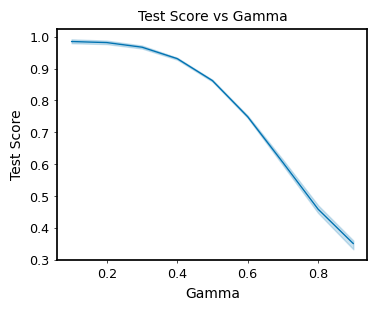

In [27]:
X_train, Y_train, X_test, Y_test = make_train_test_matrices()
results = {'gamma': [], 'test_score': []}
for gamma in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    pipeline, test_score = fit_and_evaluate_regression(X_train, Y_train, X_test, Y_test, gamma, print_scores=False)
    results['gamma'].extend([gamma]*len(test_score))
    results['test_score'].extend(test_score)

results = pd.DataFrame(results)
plt.figure(figsize=(4, 3))
sns.lineplot(x='gamma', y='test_score', data=results)
plt.xlabel('Gamma')
plt.ylabel('Test Score')
plt.title('Test Score vs Gamma')
plt.show()


# Examine chosen gamma value

In [28]:
gamma = 0.8

In [29]:
pipelines, test_score = fit_and_evaluate_regression(X_train, Y_train, X_test, Y_test, gamma)

Layer 0:
Best alpha: 464.159
Train R2: 0.463
Test R2: 0.447

Layer 1:
Best alpha: 1291.550
Train R2: 0.466
Test R2: 0.458

Layer 2:
Best alpha: 464.159
Train R2: 0.489
Test R2: 0.471



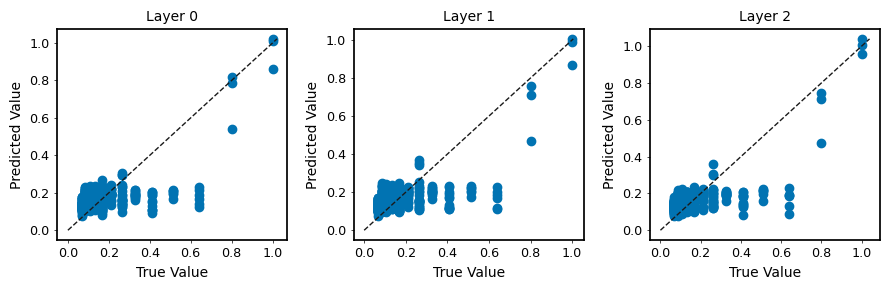

In [30]:
X_train_np = [np.array([_x.cpu().numpy() for _x in x]) for x in X_train]
X_test_np = [np.array([_x.cpu().numpy() for _x in x]) for x in X_test]
Y_train_np = np.array(Y_train)
Y_test_np = np.array(Y_test)
Y_train_np = gamma**Y_train_np
Y_test_np = gamma**Y_test_np

fig, axes = plt.subplots(1, len(pipelines), figsize=(3*len(pipelines), 3))
for layer, (pipeline, ax) in enumerate(zip(pipelines, axes)):
    y_pred = pipeline.predict(X_test_np[layer])
    max_val = max(Y_test_np.max(), y_pred.max())
    ax.scatter(Y_test_np, y_pred, label='Test')
    ax.plot([0, max_val], [0, max_val], 'k--', label='Perfect Prediction')  # Add diagonal line
    ax.set_xlabel('True Value')
    ax.set_ylabel('Predicted Value')
    ax.set_title(f'Layer {layer}')
plt.tight_layout()
plt.show()

## Show an example environment 

In [31]:
i_eval = test_envs[2]
traj = eval_trajs[i_eval]
seen_states = np.vstack((traj['context_states'][:1], traj['context_next_states']))
seen_states = np.unique(seen_states, axis=0) 
first_reward = np.argwhere(np.array(traj['context_rewards'])>0)
if (first_reward.size == 0) or (first_reward[0] > 1000):
    print("No reward found")
else:
    X = [[] for _ in range(model.n_layer)]
    Y = []
    states = []
    env_config = {
        'max_layers': 7,
        'horizon': 1600,
        'branching_prob': 1.0,
        'node_encoding_corr': corr,
        'state_dim': state_dim,
        'initialization_seed': np.array(traj['initialization_seed']).item()
    }
    env = EvalCntrees().create_env(env_config, np.array(traj['goal']), i_eval)
    _, dist_from_goal = env.make_opt_action_dict()

    seq_length = 1000
    hidden_states = run_model(traj, model, seen_states, seq_length)
    for state_idx, state_feature in enumerate(seen_states):
        state_feature = tuple(state_feature.tolist())
        state_node = env.node_map[state_feature]
        d = dist_from_goal[state_feature]
        val = d
        Y.append(val)
        states.append((state_node.layer, state_node.pos))
        for layer in range(model.n_layer):
            hidden_state = hidden_states[layer][state_idx][0, -1]
            X[layer].append(hidden_state)


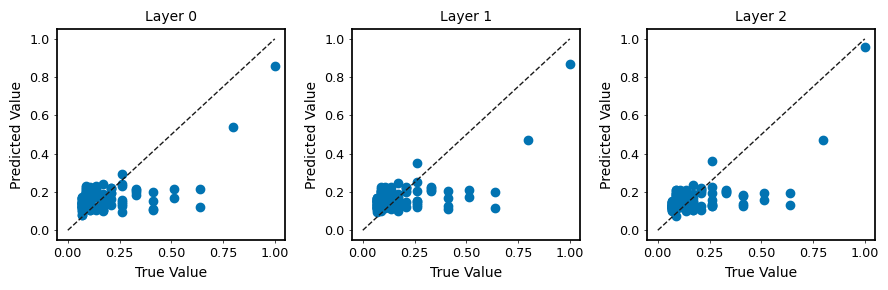

In [32]:
X_np = [np.array([_x.cpu().numpy() for _x in x]) for x in X]
Y_np = np.array(Y)
Y_np = gamma**Y_np

fig, axes = plt.subplots(1, len(pipelines), figsize=(3*len(pipelines), 3))
for layer, (pipeline, ax) in enumerate(zip(pipelines, axes)):
    y_pred = pipeline.predict(X_np[layer])
    max_val = max(Y_np.max(), y_pred.max())
    ax.scatter(Y_np, y_pred, label='Test')
    ax.plot([0, max_val], [0, max_val], 'k--', label='Perfect Prediction')  # Add diagonal line
    ax.set_xlabel('True Value')
    ax.set_ylabel('Predicted Value')
    ax.set_title(f'Layer {layer}')
plt.tight_layout()
plt.show()

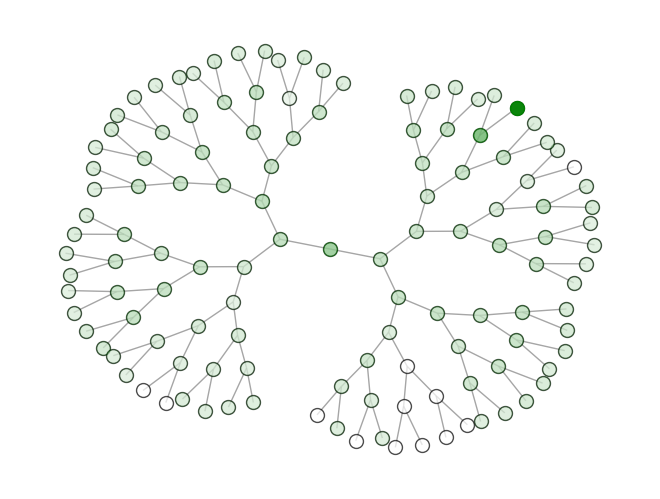

In [33]:
import networkx as nx
G = env.to_networkx()
pos = nx.kamada_kawai_layout(G)

# First draw all edges and nodes in default style
nx.draw(G, pos,
       node_color='white',
       edge_color='gray', 
       node_size=100,
       font_size=8,
       font_weight='bold',
       width=1,
       alpha=0.7,
       edgecolors='black')

for idx, state in enumerate(states):
    nx.draw_networkx_nodes(G, pos,
        nodelist=[state],
        node_color='green',
        node_size=100,
        alpha=np.clip(y_pred[idx], 0, 1))
plt.show()

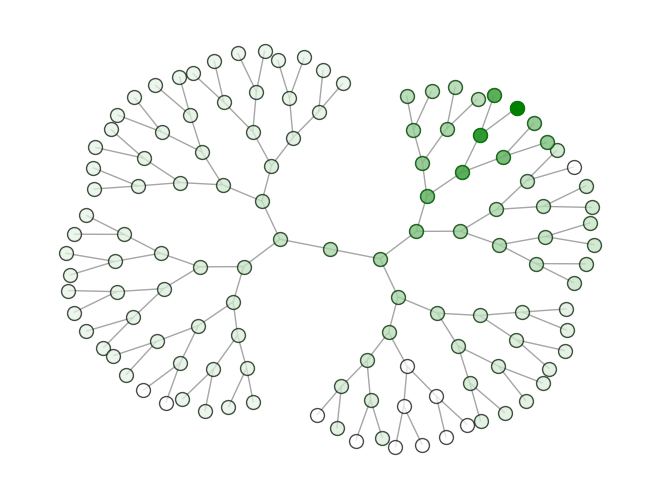

In [34]:
import networkx as nx
G = env.to_networkx()
pos = nx.kamada_kawai_layout(G)

# First draw all edges and nodes in default style
nx.draw(G, pos,
       node_color='white',
       edge_color='gray', 
       node_size=100,
       font_size=8,
       font_weight='bold',
       width=1,
       alpha=0.7,
       edgecolors='black')

for idx, state in enumerate(states):
    nx.draw_networkx_nodes(G, pos,
        nodelist=[state],
        node_color='green',
        node_size=100,
        alpha=Y_np[idx])
plt.show()